<a href="https://colab.research.google.com/github/muhammadefan/just_do_it/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

by Muhammad Efan Abdulfattah

here i am using: SETT dataset (https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess)


#### Data Preparation & Preprocessing

In [ ]:
# import some libraries
import matplotlib.pyplot as plt # visualization
import seaborn as sns # more visualization
import pandas as pd # tabular data processing
import numpy as np
import librosa # audio processing
import os
import csv
import warnings

warnings.filterwarnings('ignore') #, category=DeprecationWarning

**Data Acquisition**

In [ ]:
# function for downloading dataset
def downloadData():
  # to check present working directory
  # %pwd

  # change directory to ...
  %cd '/content/drive/MyDrive/learning py/dataset'

  # to enable in accessing kaggle.json
  os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/learning py/dataset'

  # download dataset and stored it to current directory
  !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

  # un-zip the zip files, then remove it
  !unzip \*.zip && rm *.zip


# execute the function
# downloadData()

**Path Defining**

In [ ]:
# MAKE SURE YOU HAVE DEFINED THE RIGHT PATH TO WHERE YOUR DATA ARE STORED
path='/content/drive/MyDrive/learning py/dataset/TESS dataset/'
csv_path = '/content/drive/MyDrive/learning py/dataset/'
# check what inside the directory
os.listdir(path)

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

#####**Feature Extraction**

In [ ]:
# create a function for exctracting some features from the dataset
def feature_extraction(pathDirectory, csvFileName, savingLocation=csv_path):
  features = 'folder_name filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
  
  # adding mfcc's columns (mfcc1, mfcc2, mfcc3, etc.)
  for i in range(1,21):
    features += f' mfcc{i}'
  # adding label's column
  features += ' label'
  # split the features name
  features = features.split(sep=' ') # whitespace separator
  
  # create and open csv file
  file = open(savingLocation+csvFileName, 'w', newline='')
  write = csv.writer(file)
  write.writerow(features)

  # load multiple audio files
  for folderName in os.listdir(pathDirectory):
    for filename in os.listdir(pathDirectory+folderName):
      audio_file = f'{pathDirectory}{folderName}/{filename}'
      y, sr = librosa.load(audio_file, duration=30) # y = signal

      # remove leading and trailing silence
      y, idx = librosa.effects.trim(y)

      # features extraction
      chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
      rmse = librosa.feature.rms(y=y)
      spec_ct = librosa.feature.spectral_centroid(y=y, sr=sr)
      spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
      rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
      zcr = librosa.feature.zero_crossing_rate(y=y)
      mfccs = librosa.feature.mfcc(y=y, sr=sr)
      
      # append those variables above into csv file
      to_append = f'{folderName} {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_ct)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
      ## mfcc features
      for mfcc in mfccs:
        to_append += f' {np.mean(mfcc)}'
      
      write.writerow(to_append.split())

  # close csv file
  file.close()
  print(f'{csvFileName} File Succesfully Created!\n')

In [ ]:
# MAKE SURE TO SET IT PROPERLY, IF YOU DON'T HAVE THE CSV FILE, SET IT TO --> True
# create csv file or not?
CREATE_CSV_FILE = True # i already possessed the files, so it's False

if CREATE_CSV_FILE == True:
  feature_extraction(path, 'train.csv')
else:
  print('Skipped')

train.csv File Succesfully Created!



In [ ]:
# data preview
df = pd.read_csv(csv_path+'train.csv')
df.head()

,folder_name,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,OAF_Fear,OAF_bar_fear.wav,0.261588,0.027230,2070.955859,2235.694048,3401.508655,0.098198,-434.153473,70.799828,12.416528,-21.082228,-7.378584,5.511951,-12.439829,0.220041,-16.291090,1.564839,-21.285177,-3.604874,-6.357632,3.724327,-6.903087,1.090240,-3.079959,0.332067,-0.539703,-4.573868,NaN
1,OAF_Fear,OAF_back_fear.wav,0.317041,0.027715,2066.449350,2248.438388,3678.588867,0.095052,-434.784576,62.292271,1.310813,-7.593494,2.342312,3.892958,-14.193316,0.295769,-11.299685,4.518313,-13.447262,-6.320590,-4.544526,-0.445772,-1.291752,2.900441,-5.883135,5.002367,2.602203,-6.823027,NaN
2,OAF_Fear,OAF_boat_fear.wav,0.295189,0.019072,2225.648327,2353.857427,3932.745916,0.099846,-469.726654,62.456905,19.089554,-2.574088,-2.879203,0.846164,-9.898459,1.825333,-16.056005,-1.097142,-13.853663,-8.575394,-5.209511,4.930333,-1.107614,4.627129,-3.891634,5.947228,-0.632763,1.162557,NaN
3,OAF_Fear,OAF_bite_fear.wav,0.259389,0.021543,2249.891920,2415.103105,4148.352693,0.100903,-439.211700,60.263371,12.520771,-3.445198,2.283303,2.585925,-11.596494,3.064018,-17.604149,-2.168778,-17.880657,-8.131488,-7.294719,0.939924,-3.133308,2.060867,-2.928276,5.854718,-1.020589,-5.064354,NaN
4,OAF_Fear,OAF_bean_fear.wav,0.275780,0.018652,2048.621712,2405.538519,3977.644043,0.083733,-491.376404,54.348557,20.316404,9.100837,8.133509,1.166301,-7.156228,2.451611,-14.904309,-2.472068,-18.564545,-5.897095,-2.820896,-1.597409,-3.578752,1.837144,-3.905771,8.383280,4.731544,8.374842,NaN


In [ ]:
df.folder_name.unique()

array(['OAF_Fear', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry',
       'OAF_disgust', 'OAF_happy', 'OAF_neutral', 'YAF_angry',
       'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral',
       'YAF_pleasant_surprised', 'YAF_sad'], dtype=object)

In [ ]:
df.label.isna().sum()

2800

#####**Labelling**

In [ ]:
# create a function for labelling the train dataset
def preprocess(csvFileName):
  # create dataframe
  df = pd.read_csv(csvFileName)

  # finding label
  label_container = []
  for i in range(len(df['folder_name'])):
    emotion = df['folder_name'][i][4:]
    if emotion == 'Fear' or emotion == 'fear':
      label = 0
    elif emotion == 'Pleasant_surprise' or emotion == 'pleasant_surprised':
      label = 1
    elif emotion == 'Sad' or emotion == 'sad':
      label = 2
    elif emotion == 'angry':
      label = 3
    elif emotion == 'disgust':
      label = 4
    elif emotion == 'happy':
      label = 5
    elif emotion == 'neutral':
      label = 6
    else:
      pass
    label_container.append(label)

  # data imputation
  df['label'] = label_container
  # drop unnecessary column
  df.drop('filename', axis=1, inplace=True)

  print('Successfully Preprocessed!')
  return df

In [ ]:
# run the preprocess function
df_train = preprocess(csv_path+'train.csv')

Successfully Preprocessed!


In [ ]:
## DATA CHECKING
# uniqueness of the label
print(f'Training Dataset Label : {df_train.label.unique()}\n')

# labelled data
for i in range(7):
  print(f'label {i} --> {df_train[df_train.label == i].folder_name.unique()}')


# since it has known that labelling process's succed, do this
# drop 'folder_name'
df_train.drop('folder_name', axis=1, inplace=True)

Training Dataset Label : [0 1 2 3 4 5 6]

label 0 --> ['OAF_Fear' 'YAF_fear']
label 1 --> ['OAF_Pleasant_surprise' 'YAF_pleasant_surprised']
label 2 --> ['OAF_Sad' 'YAF_sad']
label 3 --> ['OAF_angry' 'YAF_angry']
label 4 --> ['OAF_disgust' 'YAF_disgust']
label 5 --> ['OAF_happy' 'YAF_happy']
label 6 --> ['OAF_neutral' 'YAF_neutral']


In [ ]:
# data preview
df_train.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.261588,0.027230,2070.955859,2235.694048,3401.508655,0.098198,-434.153473,70.799828,12.416528,-21.082228,-7.378584,5.511951,-12.439829,0.220041,-16.291090,1.564839,-21.285177,-3.604874,-6.357632,3.724327,-6.903087,1.090240,-3.079959,0.332067,-0.539703,-4.573868,0
1,0.317041,0.027715,2066.449350,2248.438388,3678.588867,0.095052,-434.784576,62.292271,1.310813,-7.593494,2.342312,3.892958,-14.193316,0.295769,-11.299685,4.518313,-13.447262,-6.320590,-4.544526,-0.445772,-1.291752,2.900441,-5.883135,5.002367,2.602203,-6.823027,0
2,0.295189,0.019072,2225.648327,2353.857427,3932.745916,0.099846,-469.726654,62.456905,19.089554,-2.574088,-2.879203,0.846164,-9.898459,1.825333,-16.056005,-1.097142,-13.853663,-8.575394,-5.209511,4.930333,-1.107614,4.627129,-3.891634,5.947228,-0.632763,1.162557,0
3,0.259389,0.021543,2249.891920,2415.103105,4148.352693,0.100903,-439.211700,60.263371,12.520771,-3.445198,2.283303,2.585925,-11.596494,3.064018,-17.604149,-2.168778,-17.880657,-8.131488,-7.294719,0.939924,-3.133308,2.060867,-2.928276,5.854718,-1.020589,-5.064354,0
4,0.275780,0.018652,2048.621712,2405.538519,3977.644043,0.083733,-491.376404,54.348557,20.316404,9.100837,8.133509,1.166301,-7.156228,2.451611,-14.904309,-2.472068,-18.564545,-5.897095,-2.820896,-1.597409,-3.578752,1.837144,-3.905771,8.383280,4.731544,8.374842,0


#####**Data Augmentation**

In [ ]:
# if you want to get better result, you can try to use some of this kind of data augmentation
# but, in this case, i don't use it
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low = -5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#### Data Modelling

In [ ]:
# import some libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

In [ ]:
# split training data for independent (X), dependent (y) features
# training & validating data = 2800 audio files
X = df_train.drop('label', axis=1)
y = df_train.label


# standardize the dataset (training & testing)
scaler = StandardScaler()

X[:] = scaler.fit_transform(X)


# split data for training & validation phase
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# MAKE SURE TO SET THIS CONDITION PROPERLY
# if you want to train the model from the beginnig or want to tune the model, set it to TRUE
# if you have possesed the 'model-ser.h5' file, you can set it to FALSE
SAVE_OR_NOT = False

```
If you have gotten model-ser.h5 file, you can go to TESTING PHASE directly!
```

#####**Training Phase**

In [ ]:
## to clear previous training session
clear_session()

## create a model
model = Sequential([Dense(256, activation='relu', input_shape=(X_train.shape[1],)), # X_train's number of columns
                    Dropout(0.5),

                    Dense(128, activation='relu'),
                    Dropout(0.5),

                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    
                    Dense(7, activation='softmax')                    
])

## print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6912      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 4

In [ ]:
## compiler
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## initiate early stopping for avoiding overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

## train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[es])

Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 1.9722 - accuracy: 0.2059 - val_loss: 1.3926 - val_accuracy: 0.7750
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 1.4984 - accuracy: 0.4293 - val_loss: 0.7979 - val_accuracy: 0.9036
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 1.0957 - accuracy: 0.5893 - val_loss: 0.3977 - val_accuracy: 0.9464
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.7645 - accuracy: 0.7395 - val_loss: 0.2202 - val_accuracy: 0.9607
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.5961 - accuracy: 0.8009 - val_loss: 0.1436 - val_accuracy: 0.9714
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4208 - accuracy: 0.8639 - val_loss: 0.0980 - val_accuracy: 0.9762
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.3747 - accuracy: 0.8835 - val_loss: 0.0845 - val_accuracy: 0.9786
Epoch 8/50
31/31 [=

In [ ]:
# this condition is derived from SAVE_OR_NOT condition
# save the model, or not?
if SAVE_OR_NOT == True:
  model.save(csv_path+'model-ser.h5')
  print('model saved!')
elif SAVE_OR_NOT == False:
  pass

model saved!


#####**Evaluating Phase**

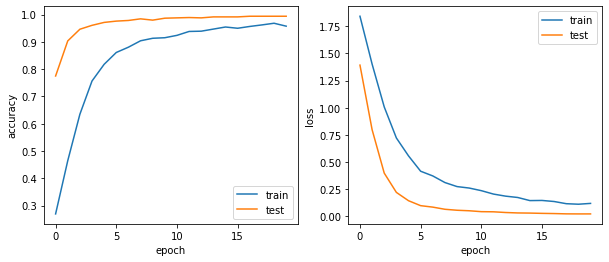

In [ ]:
# training result viz
fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


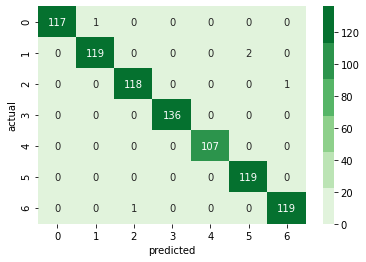

In [ ]:
# predicting on validation data
y_pred = model.predict_classes(X_val)

# evaluate the model
cmx = confusion_matrix(y_pred, y_val)

color = sns.color_palette('Greens')
sns.heatmap(cmx, annot=True, cmap=color, fmt='d')

plt.xlabel('predicted')
plt.ylabel('actual')

plt.show()

In [ ]:
# evaluate the model
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           1       0.99      0.98      0.99       121
           2       0.99      0.99      0.99       119
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       107
           5       0.98      1.00      0.99       119
           6       0.99      0.99      0.99       120

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



#####**Testing Phase**

In [ ]:
from keras.models import load_model

In [ ]:
# this condition is derived from SAVE_OR_NOT condition
# load the model, or not?
if SAVE_OR_NOT == False:
  model = load_model(csv_path+'model-ser.h5')
  print('model loaded!')
elif SAVE_OR_NOT == True:
  print('Skipped')

model loaded!


######**Testing on a Random File**

In [ ]:
import random
import IPython.display as ipd

In [ ]:
# extract the feature
def feature_extraction_test(audioFile, csvFileName):
  print(f'Saving {audioFile} features into {csvFileName}')
  features = 'chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
  for i in range(1,21):
    features += f' mfcc{i}'
  features = features.split()
  print('Extracted Features:',features) # csv file's columns
  
  # create and open csv file
  file = open(csvFileName, 'w', newline='')
  write = csv.writer(file)  
  write.writerow(features)

  # load the audio file
  y, sr = librosa.load(audioFile, duration=30) # y = signal

  # remove leading and trailing silence
  y, idx = librosa.effects.trim(y)

  # features extraction
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rms(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y=y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  # append those features into csv file
  to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
  for e in mfcc:
    to_append += f' {np.mean(e)}'
  
  write.writerow(to_append.split())

  # close csv file
  file.close()
  print('-'*34,f'\n{csvFileName} File Succesfully Created!\n'+'-'*34)

In [ ]:
# naming function
def naming(result):
  if result == 0:
    emotion = 'Fear'
  elif result == 1:
    emotion = 'Pleasant Surprise'
  elif result == 2:
    emotion = 'Sad'
  elif result == 3:
    emotion = 'Angry'
  elif result == 4:
    emotion = 'Disgust'
  elif result == 5:
    emotion = 'Happy'
  elif result == 6:
    emotion = 'Neutral'
  else:
    emotion = 'Not Identified!'
  return 'it is a '+emotion+' Feeling'

In [ ]:
# test the model using random .wav file
folder = os.listdir(path)
folder = folder[random.randint(0, len(folder)-1)]

files = os.listdir(path+folder)
files = files[random.randint(0,len(files)-1)]

# define the path to audiofile
audiofile = f'{path}{folder}/{files}'

# audiofile preview
print(audiofile,end='\n\n')
# displaying audiofile
ipd.Audio(audiofile)

/content/drive/MyDrive/learning py/dataset/TESS dataset/OAF_neutral/OAF_take_neutral.wav



In [ ]:
# extract the audio
feature_extraction_test(audiofile,f'number-{files[0]}-test.csv')

# read the data
df_single_test = pd.read_csv(f'number-{files[0]}-test.csv')

# standardize the data
df_single_test[:] = scaler.transform(df_single_test)

# predict the data
result = model.predict_classes(df_single_test)

# result showing
naming(result[0])

Saving /content/drive/MyDrive/learning py/dataset/TESS dataset/OAF_neutral/OAF_take_neutral.wav features into number-O-test.csv
Extracted Features: ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
---------------------------------- 
number-O-test.csv File Succesfully Created!
----------------------------------


'it is a Neutral Feeling'

######**Testing on a New Audio File**

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO

In [ ]:
# shout out to: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
# for working on this

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

In [ ]:
# create a function for recording & saving an audio data
def record(sec=4): # sec -> recording duration
  print('say something...')

  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])

  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'
  

# run the function
record()

say something...


<IPython.core.display.Javascript object>

'audio.wav'

In [ ]:
# data preview
ipd.Audio('audio.wav')

In [ ]:
# extract the audio
feature_extraction_test(audiofile,'audio.csv')

# read the data
df_single_test = pd.read_csv('audio.csv')

# standardize the data
df_single_test[:] = scaler.transform(df_single_test)

# predict the data
result = model.predict_classes(df_single_test)

# result showing
naming(result[0])

Saving /content/drive/MyDrive/learning py/dataset/TESS dataset/OAF_Pleasant_surprise/OAF_life_ps.wav features into audio.csv
Extracted Features: ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
---------------------------------- 
audio.csv File Succesfully Created!
----------------------------------


'it is a Pleasant Surprise Feeling'